In [ ]:
pip install wget

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import wget
import tarfile

In [ ]:
### DOWNLOAD DATA ###

link = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'

wget.download(link)


'imagenette2-160 (2).tgz'

In [ ]:
### EXTRACT DATA ###

tf = tarfile.open('imagenette2-160.tgz')

tf.extractall('./data')

In [ ]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train = torchvision.datasets.ImageFolder(root='./data/imagenette2-160/train', transform=transform)

trainloader = DataLoader(train, batch_size=64, shuffle=True)


val = torchvision.datasets.ImageFolder(root='./data/imagenette2-160/val', transform=transform)

valloader = DataLoader(val, batch_size=64, shuffle=True)



In [ ]:
def show_image(image_tensor, title, num_images=20, size=(3,28,28), nrow=5):
  plt.rcParams['figure.figsize'] = (8,8)
  image_tensor = (image_tensor + 1)/2
  image_unflat = image_tensor.detach().cpu()
  image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=nrow)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.title(title)
  plt.show

Dimensions:  torch.Size([64, 3, 64, 64])


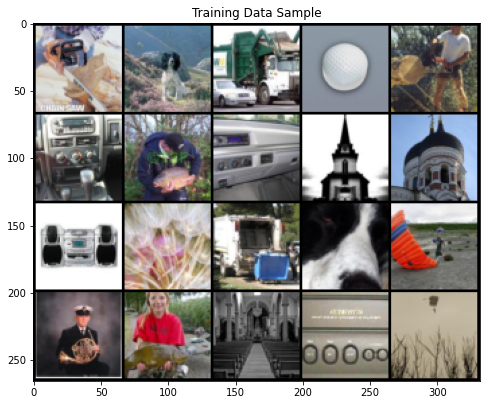

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_image(images, 'Training Data Sample')

print('Dimensions: ', images.size())

In [ ]:
### CREATE THE MACHINE ###

class VAE(nn.Module):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    ### ENCODER LAYERS ###
    self.lin1 = nn.Linear(3 * 64 * 64, 400)
    self.lin2mu = nn.Linear(400, z_dim)   # encode means
    self.lin2var = nn.Linear(400, z_dim)  # encode variances

    ### DECODER LAYERS ###
    self.lin3 = nn.Linear(z_dim, 400)
    self.lin4 = nn.Linear(400, 3 * 64 * 64)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.rand_like(std)    # create IID standard normal with same shape as z
    return eps.mul(std).add_(mu)

  def forward(self, x):
    x = x.view(-1, 3 * 64 * 64)
    x = F.relu(self.lin1(x))
    mu = self.lin2mu(x)
    var = self.lin2var(x)
    z = self.reparameterize(mu, var)
    x = self.decode(z)
    return x, mu, var

  def decode(self, x):
    x = F.relu(self.lin3(x))
    x = torch.sigmoid(self.lin4(x))
    return x

In [ ]:
### LOSS FUNCTION: RECONSTRUCTION LOSS + KL DIVERGENCE ###

def loss_term(x, x_hat, mu, var):
  CE = F.binary_cross_entropy(x_hat, x.view(-1, 3* 64 * 64), reduction='sum')
  KLD = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
  return CE + KLD

In [ ]:
### OPT AND HYPERPARAMETERS ###

vae = VAE(z_dim=15)

lr = 1e-5
opt = optim.Adam(vae.parameters(), lr=lr)


Epoch: 1, Average Loss: 101.64261423810234
Epoch: 2, Average Loss: -94.29495676673139
Epoch: 3, Average Loss: -424.37761230371535
Epoch: 4, Average Loss: -805.8306605468622
Epoch: 5, Average Loss: -1115.0399477833944
Epoch: 6, Average Loss: -1316.077780226059
Epoch: 7, Average Loss: -1434.4177706745609
Epoch: 8, Average Loss: -1506.9869129949932
Epoch: 9, Average Loss: -1569.8854830727837
Epoch: 10, Average Loss: -1616.933711226474
Epoch: 11, Average Loss: -1651.7824040367814
Epoch: 12, Average Loss: -1675.5585335002786
Epoch: 13, Average Loss: -1711.3072565767889
Epoch: 14, Average Loss: -1728.2499034949465
Epoch: 15, Average Loss: -1750.2332092297731
Epoch: 16, Average Loss: -1769.2570517263841
Epoch: 17, Average Loss: -1790.9463606652598
Epoch: 18, Average Loss: -1818.8505650962634
Epoch: 19, Average Loss: -1823.6678744158028
Epoch: 20, Average Loss: -1852.7660504743478
Epoch: 21, Average Loss: -1868.1442129726813
Epoch: 22, Average Loss: -1876.1776668180812
Epoch: 23, Average Loss:

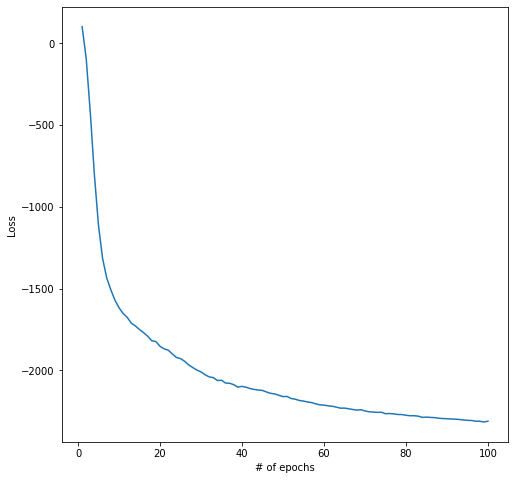

In [ ]:
### TRAINING LOOP ###

epochs = 100
loss_curve = []

for epoch in range(epochs):
  total_loss = 0
  for i, data in enumerate(trainloader, 0):
    x, _ = data
    opt.zero_grad()
    x_hat, mu, var = vae(x)
    loss = loss_term(x, x_hat, mu, var)
    loss.backward()
    total_loss += loss.item()/len(x)
    opt.step()
  avg_epoch_loss = total_loss/ len(trainloader.dataset)
  print(f'Epoch: {epoch+1}, Average Loss: {avg_epoch_loss}')
  loss_curve.append(avg_epoch_loss)

epoch_range = list(range(1, epochs+1))
plt.plot(epoch_range, loss_curve)
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()

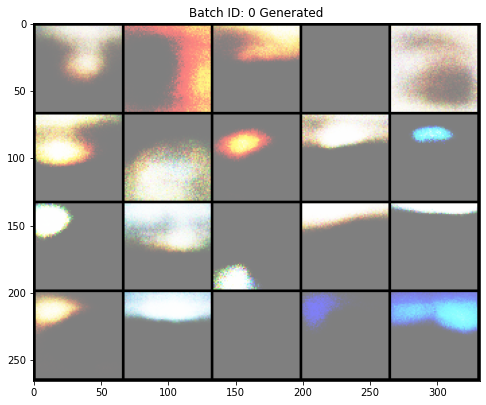

In [ ]:
### TESTING LOOP ###

with torch.no_grad():
  for i, data in enumerate(valloader):
    x, _ = data
    x_hat, mu, var = vae(x)
    x_hat_ = x_hat.view(-1, 3, 64, 64)
    if i % 100 == 0:
      show_image(x, f'Batch ID: {i} Original')
      show_image(x_hat_, f'Batch ID: {i} Generated')
 